<a href="https://colab.research.google.com/github/jonathancagua/NLP/blob/main/EX/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Versión corta del desafío:**

Crear un modelo de lenguaje carácter a carácter usando redes recurrentes (SimpleRNN, LSTM o GRU). Se debe preprocesar el texto, estructurar el problema como many-to-many, entrenar con RMSprop, evaluar con perplejidad y generar texto con técnicas como greedy, beam search y muestreo con temperatura.


In [1]:
import requests
import re
import os
import tensorflow as tf
import heapq
import numpy as np

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:

url = "https://www.gutenberg.org/files/45438/45438-0.txt"

def descargar_texto(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        texto = response.text
        print(f"Texto descargado con éxito ({len(texto)} caracteres).")
        return texto
    except requests.exceptions.RequestException as e:
        print("Error al descargar el texto:", e)
        return None

def limpiar_texto(texto, inicio, fin):
    # Buscar los índices de inicio y fin
    start_idx = texto.find(inicio)
    end_idx = texto.rfind(fin)

    if start_idx == -1 or end_idx == -1:
        print("No se encontraron los marcadores de inicio o fin.")
        return None

    texto_recortado = texto[start_idx:end_idx]

    # Limpiar múltiples espacios, saltos de línea y caracteres raros
    texto_limpio = re.sub(r'\s+', ' ', texto_recortado).strip()
    return texto_limpio

In [3]:
# Descargar y limpiar el texto
texto_crudo = descargar_texto(url)

if texto_crudo:
    inicio = "La isla del tesoro"
    fin = "FIN"

    texto_limpio = limpiar_texto(texto_crudo, inicio, fin)

    if texto_limpio:
        print("Texto limpio (primeros 1000 caracteres):\n")
        print(texto_limpio[:1000])

Texto descargado con éxito (541567 caracteres).
Texto limpio (primeros 1000 caracteres):

La isla del tesoro, by Robert Louis Stevenson This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org/license Title: La isla del tesoro Author: Robert Louis Stevenson Translator: Manuel Caballero Release Date: April 19, 2014 [EBook #45438] Language: Spanish *** START OF THIS PROJECT GUTENBERG EBOOK LA ISLA DEL TESORO *** Produced by Mark C. Orton, Chuck Greif and the Online Distributed Proofreading Team at http://www.pgdp.net (This book was produced from scanned images of public domain material from the Google Print project.) LA ISLA DEL TESORO "=La Guardia Blanca.=--Es el título de una novela escrita en inglés por Conan Doyle y publicada en español por la casa de Appleton de Nueva York, que acabamos de leer 

In [4]:
# Definir longitud de secuencia (100 caracteres de entrada + 1 para el siguiente carácter)
seq_length = 100

# Crear la capa de vectorización
vectorizer = TextVectorization(
    standardize=None,              # No queremos limpieza adicional
    split='character',             # Tokenización por carácter
    output_mode='int',             # Salida como enteros
    output_sequence_length=seq_length + 1
)

# Adaptar el vectorizador al texto limpio
vectorizer.adapt([texto_limpio])

# Obtener vocabulario y tamaño
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)

print("Tamaño del vocabulario (caracteres únicos):", vocab_size)
print("Primeros 20 tokens del vocabulario:", vocab[:20])

Tamaño del vocabulario (caracteres únicos): 99
Primeros 20 tokens del vocabulario: ['', '[UNK]', np.str_(' '), np.str_('e'), np.str_('a'), np.str_('o'), np.str_('s'), np.str_('n'), np.str_('r'), np.str_('l'), np.str_('i'), np.str_('d'), np.str_('u'), np.str_('t'), np.str_('c'), np.str_('m'), np.str_('p'), np.str_('b'), np.str_(','), np.str_('q')]


In [5]:
# Parámetros
seq_length = 100       # longitud de entrada
batch_size = 64        # tamaño del batch
buffer_size = 10000    # para shuffle
val_split = 0.1        # porcentaje para validación

# Vectorizador SIN truncamiento
full_vectorizer = TextVectorization(
    standardize=None,
    split='character',
    output_mode='int'
)
full_vectorizer.adapt([texto_limpio])

# Convertir texto limpio en tensores de enteros
vectorized_text = tf.squeeze(full_vectorizer([texto_limpio]))

# Crear dataset de secuencias deslizantes (longitud 101: 100 entrada + 1 target)
sequences = tf.data.Dataset.from_tensor_slices(vectorized_text)
sequences = sequences.window(seq_length + 1, shift=1, drop_remainder=True)
sequences = sequences.flat_map(lambda window: window.batch(seq_length + 1))

# Separar entrada y objetivo
def split_input_target(seq):
    input_seq = seq[:-1]
    target_seq = seq[1:]
    return input_seq, target_seq

sequences = sequences.map(split_input_target, num_parallel_calls=tf.data.AUTOTUNE)

# Contar número total de secuencias
total_sequences = sequences.reduce(0, lambda count, _: count + 1).numpy()
print("Total de secuencias:", total_sequences)

# División en conjunto de entrenamiento y validación
val_size = int(total_sequences * val_split)
indexed_sequences = sequences.enumerate()

# Dataset de validación
val_dataset = (
    indexed_sequences
    .filter(lambda i, _: i < val_size)
    .map(lambda _, seq: seq, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset de entrenamiento
train_dataset = (
    indexed_sequences
    .filter(lambda i, _: i >= val_size)
    .map(lambda _, seq: seq, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)


Total de secuencias: 499887


In [6]:
from tensorflow.keras import backend as K
# Limpiar sesiones anteriores (buena práctica al reentrenar)
K.clear_session()

# Vocabulario
vocab = full_vectorizer.get_vocabulary()
vocab_size = len(vocab)

# Hiperparámetros
embedding_dim = 256
lstm_units = 512

# Definir modelo secuencial
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(lstm_units, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

# Función de métrica: Perplejidad
def perplexity(y_true, y_pred):
    loss = K.sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(K.mean(loss))

# Compilar modelo
model.compile(
    optimizer=RMSprop(learning_rate=0.001),  # puede ajustarse más adelante
    loss='sparse_categorical_crossentropy',
    metrics=[perplexity]
)

# Construir el modelo con la forma esperada de entrada
model.build(input_shape=(None, seq_length))

# Mostrar resumen
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 256)       │        25,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 99)        │        50,787 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,651,043 (6.30 MB)

 Trainable params: 1,651,043 (6.30 MB)

 Non-trainable params: 0 (0.00 B)

Tu modelo LSTM de generación de texto carácter a carácter cuenta con aproximadamente 1.65 millones de parámetros, lo que le brinda una buena capacidad para aprender patrones complejos en el lenguaje, sin ser excesivamente grande. La arquitectura, compuesta por una capa de embedding, una LSTM con 512 unidades y una capa densa de salida, está bien equilibrada para capturar relaciones a largo plazo entre caracteres. Es adecuado para tareas de modelado de lenguaje, permitiendo generar texto coherente una vez entrenado. La forma de salida (None, 100, 99) asegura que el modelo predice una secuencia completa de caracteres, siendo ideal para aplicaciones como autocompletado o generación creativa.

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 144s 131ms/step - loss: 1.4617 - perplexity: 4.3615 - val_loss: 2.0143 - val_perplexity: 9.6359
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 143s 144ms/step - loss: 1.0401 - perplexity: 2.8353 - val_loss: 2.2346 - val_perplexity: 12.9620
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 143s 143ms/step - loss: 0.8011 - perplexity: 2.2337 - val_loss: 2.4619 - val_perplexity: 17.3994
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 145s 145ms/step - loss: 0.5744 - perplexity: 1.7788 - val_loss: 2.6179 - val_perplexity: 24.3108


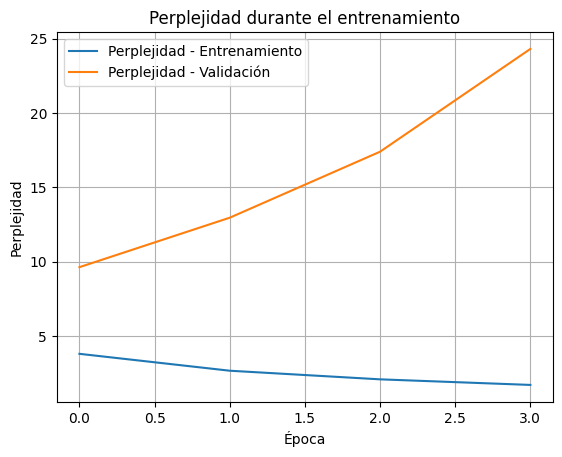

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Guardar el mejor modelo basado en perplejidad
checkpoint = ModelCheckpoint(
    filepath='modelo_lstm_char.keras',
    monitor='val_perplexity',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

# Early stopping para evitar sobreajuste
early_stop = EarlyStopping(
    monitor='val_perplexity',
    patience=3,
    restore_best_weights=True,
    mode='min'
)

# ⚙️ Pasar la cantidad de batches por época (calculada previamente)
steps_per_epoch = 1000

# Entrenar el modelo correctamente
history = model.fit(
    train_dataset.repeat(),             # <-- permite múltiples épocas
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stop, checkpoint]
)

import matplotlib.pyplot as plt

plt.plot(history.history['perplexity'], label='Perplejidad - Entrenamiento')
plt.plot(history.history['val_perplexity'], label='Perplejidad - Validación')
plt.xlabel('Época')
plt.ylabel('Perplejidad')
plt.legend()
plt.grid(True)
plt.title('Perplejidad durante el entrenamiento')
plt.show()


In [24]:
# Diccionarios de mapeo: índice <-> carácter
vocab = full_vectorizer.get_vocabulary()
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for i, c in enumerate(vocab)}

# Codificar texto a índices
def encode_text(text):
    return [char2idx.get(c, char2idx['[UNK]']) for c in text] if '[UNK]' in char2idx else [char2idx.get(c, 1) for c in text]

# Decodificar secuencia de índices a texto
def decode_sequence(seq):
    return ''.join([idx2char.get(i, '') for i in seq])

# Función de generación con estrategia greedy
def generate_greedy(model, start_text, length=300):
    # Codificar texto inicial
    input_eval = tf.expand_dims(encode_text(start_text), 0)
    generated = list(input_eval.numpy()[0])

    # Generar nuevos caracteres uno por uno
    for _ in range(length):
        # Predecir la distribución de probabilidad para el siguiente carácter
        predictions = model(input_eval)
        predictions = predictions[:, -1, :]  # Tomar la última predicción

        # Elegir el carácter más probable (greedy)
        next_id = tf.argmax(predictions, axis=-1).numpy()[0]

        # Agregar y preparar nuevo input
        generated.append(next_id)
        input_eval = tf.expand_dims(generated[-seq_length:], 0)

    # Decodificar la secuencia generada
    return decode_sequence(generated)



In [30]:
print(generate_greedy(model, "Había una vez", length=300))

Había una vez en el mismo inmediatamente y al más así en que no había visto de las merinos y contentar á nuestros habría de aquel momento, recirán aquí, en la primera ojeada que estaba en la marinero, y de nuevo á lo que hacía en su estaba á su servió y se precipitón, y se freía muy contramente y con esta verdad


Conclusion: no existe frases repetitivas y tiene coherencia lo que parece que el modelo aprendio bien en epoch de 1000


In [32]:
import numpy as np
import heapq
import tensorflow as tf

def generate_beam_search(model, start_text, length=300, beam_width=3):
    input_ids = encode_text(start_text)
    sequences = [(0.0, input_ids)]

    for _ in range(length):
        all_candidates = []
        for log_prob, seq in sequences:
            input_eval = tf.expand_dims(seq[-seq_length:], 0)
            predictions = model(input_eval)
            predictions = predictions[:, -1, :].numpy()[0]

            # Tomamos los top-k candidatos
            top_k_ids = np.argsort(predictions)[-beam_width:][::-1]

            for idx in top_k_ids:
                prob = predictions[idx]
                candidate = (log_prob + np.log(prob + 1e-10), seq + [idx])
                all_candidates.append(candidate)

        # Mantener solo los beam_width mejores
        sequences = heapq.nlargest(beam_width, all_candidates, key=lambda x: x[0])

    # Devolver la mejor secuencia generada
    best_seq = max(sequences, key=lambda x: x[0])[1]
    return decode_sequence(best_seq)


In [33]:
generate_beam_search(model, "Había una vez", length=300, beam_width=5)

'Había una vez en el mismo inmediatamente y yo nos habríamos de los parroquianos que estaban en aquellos momentos, con una verdadera todos los marineros que estaban concontramente á aquel momento, por una verdadera todos los marineros que estaban concontramente á aquel momento, por una verdadera todos los marinos'

In [34]:
def generate_beam_search_stochastic(model, start_text, length=300, beam_width=3, temperature=1.0):
    assert temperature > 0, "La temperatura debe ser mayor que cero."
    assert beam_width >= 1, "El beam_width debe ser al menos 1."

    epsilon = 1e-8
    input_ids = encode_text(start_text)
    sequences = [(0.0, input_ids)]  # Lista de (log_prob acumulada, secuencia)

    for _ in range(length):
        all_candidates = []

        for log_prob, seq in sequences:
            input_eval = tf.expand_dims(seq[-seq_length:], 0)
            predictions = model(input_eval)
            logits = predictions[:, -1, :].numpy()[0]

            # Aplicar temperatura y convertir a distribución de probabilidad
            scaled_logits = np.log(np.maximum(logits, epsilon)) / temperature
            probs = np.exp(scaled_logits - np.max(scaled_logits))  # estabilidad numérica
            probs /= np.sum(probs)

            # Muestreo estocástico de los próximos candidatos
            sampled_ids = np.random.choice(len(probs), size=beam_width, replace=False, p=probs)

            for idx in sampled_ids:
                new_log_prob = log_prob + np.log(np.maximum(probs[idx], epsilon))
                new_seq = seq + [idx]
                all_candidates.append((new_log_prob, new_seq))

        # Mantener los beam_width mejores candidatos
        sequences = heapq.nlargest(beam_width, all_candidates, key=lambda x: x[0])

    # Retornar la mejor secuencia generada
    best_seq = max(sequences, key=lambda x: x[0])[1]
    return decode_sequence(best_seq)


In [36]:
generate_beam_search_stochastic(
    model,
    start_text="Había una vez",
    length=300,
    beam_width=5,
    temperature=0.8
)

'Había una vez en el mismo inmediatamente. Hawkins ese es todo un hombre, con una verdadera todos los marinos de todos los marineros que yo tenía yo con ese estaba el Caballero Trelawney ya de los aparejos con el caballero Trelawney? Tener yo con ese estaba el Caballero Trelawney ya de los marineros que estaban a'

Mejor usos de personajes,mejor creatividad gracias a temperatura. Con buena estrucutra narrativa.

In [38]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00


In [39]:
import gradio as gr

# Función general de generación
def generar_texto(input_text, estrategia, longitud, beam_width, temperatura):
    if not input_text.strip():
        return "Por favor ingresa un texto inicial."

    try:
        if estrategia == "Greedy":
            return generate_greedy(model, input_text, length=longitud)
        elif estrategia == "Beam search determinístico":
            return generate_beam_search(model, input_text, length=longitud, beam_width=beam_width)
        elif estrategia == "Beam search estocástico":
            return generate_beam_search_stochastic(
                model, input_text, length=longitud, beam_width=beam_width, temperature=temperatura
            )
        else:
            return "Estrategia no válida."
    except Exception as e:
        return f"Error durante la generación: {str(e)}"

# Interfaz Gradio
gr.Interface(
    fn=generar_texto,
    inputs=[
        gr.Textbox(lines=2, label="Texto inicial", placeholder="Ej: Había una vez...", max_lines=4),
        gr.Radio(
            ["Greedy", "Beam search determinístico", "Beam search estocástico"],
            label="Estrategia de generación"
        ),
        gr.Slider(100, 1000, value=300, step=50, label="Longitud del texto generado"),
        gr.Slider(1, 10, value=3, step=1, label="Beam width (solo para beam search)"),
        gr.Slider(0.2, 2.0, value=1.0, step=0.1, label="Temperatura (solo para beam estocástico)")
    ],
    outputs=gr.Textbox(label="Texto generado"),
    title="Generador de Texto con LSTM",
    description="Explora diferentes estrategias de generación usando un modelo LSTM entrenado con el texto de *La isla del tesoro*.",
    theme="default",
    allow_flagging="never"
).launch(share=True)


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e70c0b6ceb30571504.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
